# Necessary Library Imports

In [1]:
from platform import python_version
print('Python version ' + python_version())
import tensorflow as tf
print('Tensorflow version ' + tf.__version__)
from tensorflow import keras as keras
print('Keras version ' + keras.__version__)
tf.config.list_physical_devices()
print(tf.config.list_physical_devices('GPU'))

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from  keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm

Python version 3.9.13
Tensorflow version 2.9.2
Keras version 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Segmentation Models: using `keras` framework.


# CNN Models

## Data preprocessing function


In [2]:
## Data preprocessing function
def preprocessData(img, mask, BACKBONE, classPixelValue):
    preprocessInput = sm.get_preprocessing(BACKBONE)
    img = preprocessInput(img)
    mask = mask/classPixelValue
    return img, mask

def trainGenerator(imgPath, maskPath, batch, seedNumber, img_size, BACKBONE, classPixelValue):
    image_datagen = ImageDataGenerator(horizontal_flip=True,
                                       vertical_flip=True)
    mask_datagen = ImageDataGenerator(horizontal_flip=True,
                                      vertical_flip=True)
    image_generator = image_datagen.flow_from_directory(
        directory=imgPath,
        target_size=img_size,
        class_mode = None,
        batch_size = batch,
        seed = seedNumber)
    mask_generator = mask_datagen.flow_from_directory(
        directory=maskPath,
        target_size=img_size,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch,
        seed = seedNumber)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = preprocessData(img, mask, BACKBONE, classPixelValue)
        yield img, mask

## Unet Model - InfiltrateWoD
### Data preprocessing

In [3]:
infiltrateWoD_trainImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/train_images'
infiltrateWoD_trainMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/train_masks/'
infiltrateWoD_valImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/val_images/'
infiltrateWoD_valMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/val_masks/'
infiltrateWoD_testImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/test_images/'
infiltrateWoD_testMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WoD/splitDataset/test_masks/'

batchSize = 2
seed = 100
imgSize = (1024, 1024)
backbone = 'resnet34'
maskPixelValue_infiltrateWoD = 1

trainDataGen_infiltrateWoD = trainGenerator(infiltrateWoD_trainImgPath, infiltrateWoD_trainMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWoD)
valDataGen_infiltrateWoD = trainGenerator(infiltrateWoD_valImgPath, infiltrateWoD_valMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWoD)
testDataGen_infiltrateWoD = trainGenerator(infiltrateWoD_testImgPath, infiltrateWoD_testMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWoD)

In [4]:
trainImgBatch_infiltrateWoD, trainMaskBatch_infiltrateWoD = trainDataGen_infiltrateWoD.__next__()
valImgBatch_infiltrateWoD, valMaskBatch_infiltrateWoD = valDataGen_infiltrateWoD.__next__()

print('trainImgs array shape: ', trainImgBatch_infiltrateWoD.shape)
print('trainMasks array shape: ', trainMaskBatch_infiltrateWoD.shape)
print('valImgs array shape: ', valImgBatch_infiltrateWoD.shape)
print('valMasks array shape: ', valMaskBatch_infiltrateWoD.shape)

Found 294 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
Found 84 images belonging to 1 classes.
Found 84 images belonging to 1 classes.
trainImgs array shape:  (2, 1024, 1024, 3)
trainMasks array shape:  (2, 1024, 1024, 1)
valImgs array shape:  (2, 1024, 1024, 3)
valMasks array shape:  (2, 1024, 1024, 1)


In [ ]:
randTrainImgNum = random.randint(0, len(trainImgBatch_infiltrateWoD)-1)
randValImgNum = random.randint(0, len(valImgBatch_infiltrateWoD)-1)
print(randTrainImgNum)
print(randValImgNum)

trainImgExample = trainImgBatch_infiltrateWoD[randTrainImgNum]
trainMaskExample = trainMaskBatch_infiltrateWoD[randTrainImgNum]

valImgExample = valImgBatch_infiltrateWoD[randValImgNum]
valMaskExample = valMaskBatch_infiltrateWoD[randValImgNum]

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(trainImgExample.astype('uint8'))
plt.subplot(142)
plt.imshow(trainMaskExample[:,:,0], cmap='gray')
plt.subplot(143)
plt.imshow(valImgExample.astype('uint8'))
plt.subplot(144)
plt.imshow(valMaskExample[:,:,0], cmap='gray')
plt.show()
print(np.unique(trainMaskExample))
print(np.unique(valMaskExample))

### Training

In [ ]:
# Unet Model
tf.compat.v1.disable_eager_execution()

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
infiltrateWoD_tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(),'Tensorboard','Binary','ResNet34','Infiltrate WoD'))
infiltrateWoD_callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(),'Saved Models','Binary','ResNet34','InfiltrateWoD_uNet_ResNet34_model.hdf5'),
                                                                monitor='val_loss', mode='min',
                                                                save_best_only=True), infiltrateWoD_tensorboard]

infiltrateWoD_uNetModel = sm.Unet(backbone_name = backbone, activation = 'sigmoid')
infiltrateWoD_uNetModel.summary()

infiltrateWoD_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

numTrainImgs = len(os.listdir(os.path.join(infiltrateWoD_trainImgPath,'train')))
numValImgs = len(os.listdir(os.path.join(infiltrateWoD_valImgPath,'val')))
trainStepsPerEpoch = numTrainImgs//batchSize
valStepsPerEpoch = numValImgs//batchSize

infiltrateWoD_uNetModel_history = infiltrateWoD_uNetModel.fit(trainDataGen_infiltrateWoD,
                                  steps_per_epoch=trainStepsPerEpoch,
                                  epochs=100,
                                  callbacks=infiltrateWoD_callbacks_list,
                                  validation_data=valDataGen_infiltrateWoD,
                                  validation_steps=valStepsPerEpoch)

In [4]:
infiltrateWoD_uNetModel = keras.models.load_model('/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Notebook/CardiacBiopsyDL/Saved Models/Binary/ResNet34/InfiltrateWoD_uNet_ResNet34_model.hdf5', compile=False)

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
infiltrateWoD_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

2022-09-28 13:04:52.934003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-28 13:04:52.934257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 555


In [9]:
infiltrateWoD_valSteps = len(os.listdir(os.path.join(infiltrateWoD_valImgPath,'val')))//batchSize
infiltrateWoD_uNetModel.evaluate_generator(valDataGen_infiltrateWoD, infiltrateWoD_valSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_797/813562477.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  infiltrateWoD_uNetModel.evaluate_generator(valDataGen_infiltrateWoD, infiltrateWoD_valSteps)


Found 84 images belonging to 1 classes.
Found 84 images belonging to 1 classes.


2022-09-28 10:41:46.199330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.4989303648471832, 0.5010696649551392, 0.780427873134613]

In [10]:
infiltrateWoD_testSteps = len(os.listdir(os.path.join(infiltrateWoD_testImgPath,'test')))//batchSize
infiltrateWoD_uNetModel.evaluate_generator(testDataGen_infiltrateWoD, infiltrateWoD_testSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_797/2857257433.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  infiltrateWoD_uNetModel.evaluate_generator(testDataGen_infiltrateWoD, infiltrateWoD_testSteps)


Found 43 images belonging to 1 classes.
Found 43 images belonging to 1 classes.


[0.5241135954856873, 0.47588640451431274, 0.7418432831764221]

In [ ]:
infiltrateWoD_uNetModel_epochs = range(0, len(infiltrateWoD_uNetModel_history.history['loss']))
infiltrateWoD_uNetModel_loss = infiltrateWoD_uNetModel_history.history['loss']
infiltrateWoD_uNetModel_valLoss = infiltrateWoD_uNetModel_history.history['val_loss']

plt.figure()
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_loss, color='red', label='Training loss')
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_valLoss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
infiltrateWoD_uNetModel_epochs = range(0, len(infiltrateWoD_uNetModel_history.history['loss']))
infiltrateWoD_uNetModel_IoUscore = infiltrateWoD_uNetModel_history.history['iou_score']
infiltrateWoD_uNetModel_valIoUscore = infiltrateWoD_uNetModel_history.history['val_iou_score']

plt.figure()
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_IoUscore, color='red', label='Training IoU score')
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_valIoUscore, color='green', label='Validation IoU score')
plt.title('Training and validation IoU score')
plt.legend()

In [ ]:
infiltrateWoD_uNetModel_epochs = range(0, len(infiltrateWoD_uNetModel_history.history['loss']))
infiltrateWoD_uNetModel_acc = infiltrateWoD_uNetModel_history.history['acc']
infiltrateWoD_uNetModel_valAcc = infiltrateWoD_uNetModel_history.history['val_acc']

plt.figure()
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_acc, color='red', label='Training acc')
plt.plot(infiltrateWoD_uNetModel_epochs, infiltrateWoD_uNetModel_valAcc, color='green', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

### Testing

In [16]:
infiltrateWoD_testImgBatch, infiltrateWoD_testMaskBatch = testDataGen_infiltrateWoD.__next__()
predictTestImg = infiltrateWoD_uNetModel.predict(infiltrateWoD_testImgBatch)

print('testImgs array shape: ', infiltrateWoD_testImgBatch.shape)
print('testMasks array shape: ', infiltrateWoD_testMaskBatch.shape)

1/1 [==============================] - 2s 2s/step
testImgs array shape:  (2, 1024, 1024, 3)
testMasks array shape:  (2, 1024, 1024, 1)


1


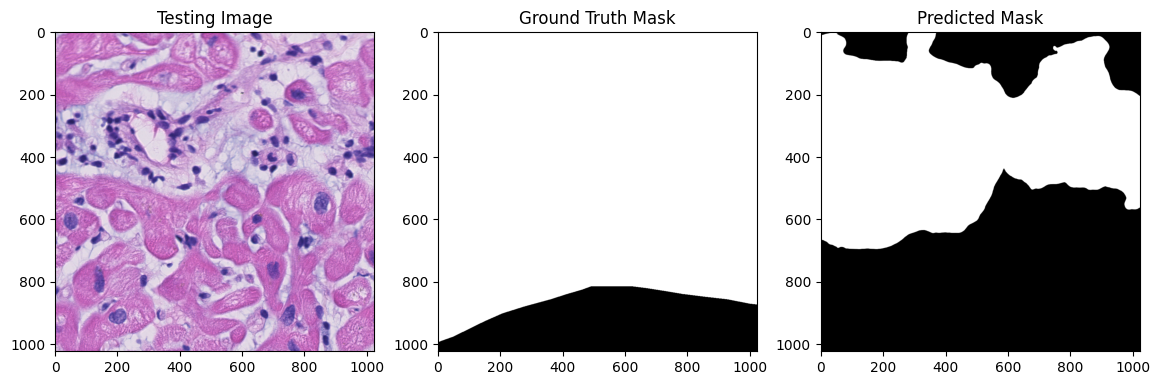

[0. 1.]
[2.3572414e-12 2.4329330e-12 2.4434415e-12 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


In [17]:
#Test some random images from
randTestImgNum = random.randint(0, len(infiltrateWoD_testImgBatch)-1)
print(randTestImgNum)
testImg = infiltrateWoD_testImgBatch[randTestImgNum]
groundTruthMask =  infiltrateWoD_testMaskBatch[randTestImgNum]
predictedMask = predictTestImg[randTestImgNum]

plt.figure(figsize=(14, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImg.astype('uint8'))
plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(groundTruthMask[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predictedMask[:,:,0], cmap='gray')
plt.show()
print(np.unique(groundTruthMask))
print(np.unique(predictedMask))

## Unet Model - InfiltrateWD
### Data preprocessing

In [18]:
infiltrateWD_trainImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/train_images/'
infiltrateWD_trainMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/train_masks/'
infiltrateWD_valImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/val_images/'
infiltrateWD_valMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/val_masks/'
infiltrateWD_testImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/test_images/'
infiltrateWD_testMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Infiltrate WD/splitDataset/test_masks/'

batchSize = 2
seed = 200
imgSize = (1024, 1024)
backbone = 'resnet34'
maskPixelValue_infiltrateWD = 2

trainDataGen_infiltrateWD = trainGenerator(infiltrateWD_trainImgPath, infiltrateWD_trainMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWD)
valDataGen_infiltrateWD = trainGenerator(infiltrateWD_valImgPath, infiltrateWD_valMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWD)
testDataGen_infiltrateWD = trainGenerator(infiltrateWD_testImgPath, infiltrateWD_testMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_infiltrateWD)

In [ ]:
trainImgBatch_infiltrateWD, trainMaskBatch_infiltrateWD = trainDataGen_infiltrateWD.__next__()
valImgBatch_infiltrateWD, valMaskBatch_infiltrateWD = valDataGen_infiltrateWD.__next__()

print('trainImgs array shape: ', trainImgBatch_infiltrateWD.shape)
print('trainMasks array shape: ', trainMaskBatch_infiltrateWD.shape)
print('valImgs array shape: ', valImgBatch_infiltrateWD.shape)
print('valMasks array shape: ', valMaskBatch_infiltrateWD.shape)

In [ ]:
randTrainImgNum = random.randint(0, len(trainImgBatch_infiltrateWD)-1)
randValImgNum = random.randint(0, len(valImgBatch_infiltrateWD)-1)
print(randTrainImgNum)
print(randValImgNum)

trainImgExample = trainImgBatch_infiltrateWD[randTrainImgNum]
trainMaskExample = trainMaskBatch_infiltrateWD[randTrainImgNum]

valImgExample = valImgBatch_infiltrateWD[randValImgNum]
valMaskExample = valMaskBatch_infiltrateWD[randValImgNum]

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(trainImgExample.astype('uint8'))
plt.subplot(142)
plt.imshow(trainMaskExample[:,:,0], cmap='gray')
plt.subplot(143)
plt.imshow(valImgExample.astype('uint8'))
plt.subplot(144)
plt.imshow(valMaskExample[:,:,0], cmap='gray')
plt.show()
print(np.unique(trainMaskExample))
print(np.unique(valMaskExample))

### Training


In [ ]:
# Unet Model
tf.compat.v1.disable_eager_execution()

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
infiltrateWD_tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(),'Tensorboard','Binary','ResNet34','Infiltrate WD'))
infiltrateWD_callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(),'Saved Models','Binary','ResNet34','infiltrateWD_uNet_ResNet34_model.hdf5'),
                                                               monitor='val_loss', mode='min',
                                                               save_best_only=True), infiltrateWD_tensorboard]

infiltrateWD_uNetModel = sm.Unet(backbone_name = backbone, activation = 'sigmoid')
infiltrateWD_uNetModel.summary()

infiltrateWD_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

numTrainImgs = len(os.listdir(os.path.join(infiltrateWD_trainImgPath,'train')))
numValImgs = len(os.listdir(os.path.join(infiltrateWD_valImgPath,'val')))
trainStepsPerEpoch = numTrainImgs//batchSize
valStepsPerEpoch = numValImgs//batchSize

infiltrateWD_uNetModel_history = infiltrateWD_uNetModel.fit(trainDataGen_infiltrateWD,
                                  steps_per_epoch=trainStepsPerEpoch,
                                  epochs=100,
                                  callbacks=infiltrateWD_callbacks_list,
                                  validation_data=valDataGen_infiltrateWD,
                                  validation_steps=valStepsPerEpoch)

### Evaluating

In [19]:
infiltrateWD_uNetModel = keras.models.load_model('/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Notebook/CardiacBiopsyDL/Saved Models/Binary/ResNet34/infiltrateWD_uNet_ResNet34_model.hdf5', compile=False)

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
infiltrateWD_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [10]:
infiltrateWD_valSteps = len(os.listdir(os.path.join(infiltrateWD_valImgPath,'val')))//batchSize
infiltrateWD_uNetModel.evaluate_generator(valDataGen_infiltrateWD, infiltrateWD_valSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_875/3648892336.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  infiltrateWD_uNetModel.evaluate_generator(valDataGen_infiltrateWD, infiltrateWD_valSteps)


Found 106 images belonging to 1 classes.
Found 106 images belonging to 1 classes.


2022-09-28 10:52:56.449046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.3985674977302551, 0.6014325022697449, 0.6801809072494507]

In [11]:
infiltrateWD_testSteps = len(os.listdir(os.path.join(infiltrateWD_testImgPath,'test')))//batchSize
infiltrateWD_uNetModel.evaluate_generator(testDataGen_infiltrateWD, infiltrateWD_testSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_875/1428492991.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  infiltrateWD_uNetModel.evaluate_generator(testDataGen_infiltrateWD, infiltrateWD_testSteps)


Found 54 images belonging to 1 classes.
Found 54 images belonging to 1 classes.


[0.36996981501579285, 0.6300302743911743, 0.688955545425415]

In [ ]:
infiltrateWD_uNetModel_epochs = range(1, len(infiltrateWD_uNetModel_history.history['loss']) + 1)
infiltrateWD_uNetModel_loss = infiltrateWD_uNetModel_history.history['loss']
infiltrateWD_uNetModel_valLoss = infiltrateWD_uNetModel_history.history['val_loss']

plt.figure()
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_loss, color='red', label='Training loss')
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_valLoss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
infiltrateWD_uNetModel_epochs = range(1, len(infiltrateWD_uNetModel_history.history['loss']) + 1)
infiltrateWD_uNetModel_IoUscore = infiltrateWD_uNetModel_history.history['iou_score']
infiltrateWD_uNetModel_valIoUscore = infiltrateWD_uNetModel_history.history['val_iou_score']

plt.figure()
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_IoUscore, color='red', label='Training IoU score')
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_valIoUscore, color='green', label='Validation IoU score')
plt.title('Training and validation IoU score')
plt.legend()

In [ ]:
infiltrateWD_uNetModel_epochs = range(1, len(infiltrateWD_uNetModel_history.history['loss']) + 1)
infiltrateWD_uNetModel_acc = infiltrateWD_uNetModel_history.history['acc']
infiltrateWD_uNetModel_valAcc = infiltrateWD_uNetModel_history.history['val_acc']

plt.figure()
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_acc, color='red', label='Training acc')
plt.plot(infiltrateWD_uNetModel_epochs, infiltrateWD_uNetModel_valAcc, color='green', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

### Testing

In [44]:
infiltrateWD_testImgBatch, infiltrateWD_testMaskBatch = testDataGen_infiltrateWD.__next__()
predictTestImg = infiltrateWD_uNetModel.predict(infiltrateWD_testImgBatch)

print('testImgs array shape: ', infiltrateWD_testImgBatch.shape)
print('testMasks array shape: ', infiltrateWD_testMaskBatch.shape)

1/1 [==============================] - 2s 2s/step
testImgs array shape:  (2, 1024, 1024, 3)
testMasks array shape:  (2, 1024, 1024, 1)


0


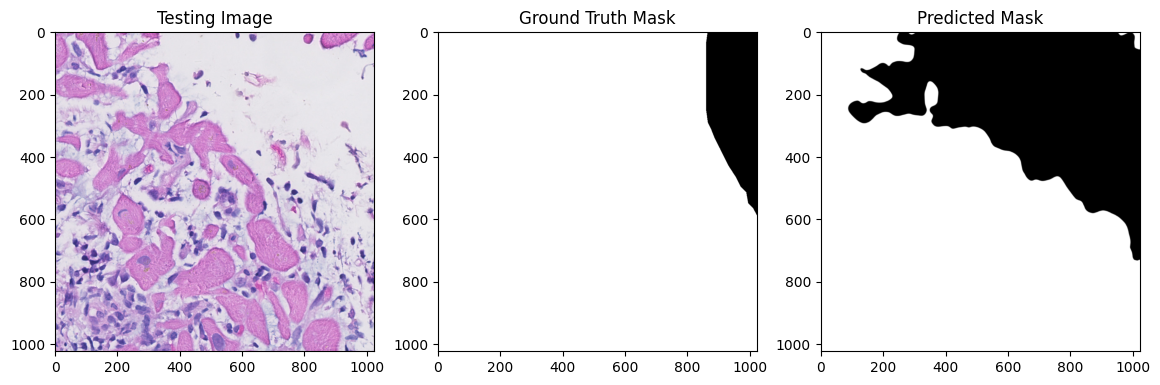

[0. 1.]
[0.0000000e+00 1.1919764e-38 1.1979736e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


In [45]:
#Test some random images from
randTestImgNum = random.randint(0, len(infiltrateWD_testImgBatch)-1)
print(randTestImgNum)
testImg = infiltrateWD_testImgBatch[randTestImgNum]
groundTruthMask =  infiltrateWD_testMaskBatch[randTestImgNum]
predictedMask = predictTestImg[randTestImgNum]

plt.figure(figsize=(14, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImg.astype('uint8'))
plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(groundTruthMask[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predictedMask[:,:,0], cmap='gray')
plt.show()
print(np.unique(groundTruthMask))
print(np.unique(predictedMask))

## Unet Model - Quilty
### Data preprocessing

In [46]:
quilty_trainImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/train_images'
quilty_trainMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/train_masks/'
quilty_valImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/val_images/'
quilty_valMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/val_masks/'
quilty_testImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/test_images/'
quilty_testMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Binary/Quilty/splitDataset/test_masks/'

batchSize = 2
seed = 300
imgSize = (1024, 1024)
backbone = 'resnet34'
maskPixelValue_quilty = 3

trainDataGen_quilty = trainGenerator(quilty_trainImgPath, quilty_trainMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_quilty)
valDataGen_quilty = trainGenerator(quilty_valImgPath, quilty_valMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_quilty)
testDataGen_quilty = trainGenerator(quilty_testImgPath, quilty_testMaskPath, batchSize, seed, imgSize, backbone, maskPixelValue_quilty)

In [21]:
trainImgBatch_quilty, trainMaskBatch_quilty = trainDataGen_quilty.__next__()
valImgBatch_quilty, valMaskBatch_quilty = valDataGen_quilty.__next__()

print('trainImgs array shape: ', trainImgBatch_quilty.shape)
print('trainMasks array shape: ', trainMaskBatch_quilty.shape)
print('valImgs array shape: ', valImgBatch_quilty.shape)
print('valMasks array shape: ', valMaskBatch_quilty.shape)

Found 223 images belonging to 1 classes.
Found 223 images belonging to 1 classes.
Found 63 images belonging to 1 classes.
Found 63 images belonging to 1 classes.
trainImgs array shape:  (2, 1024, 1024, 3)
trainMasks array shape:  (2, 1024, 1024, 1)
valImgs array shape:  (2, 1024, 1024, 3)
valMasks array shape:  (2, 1024, 1024, 1)


1
1


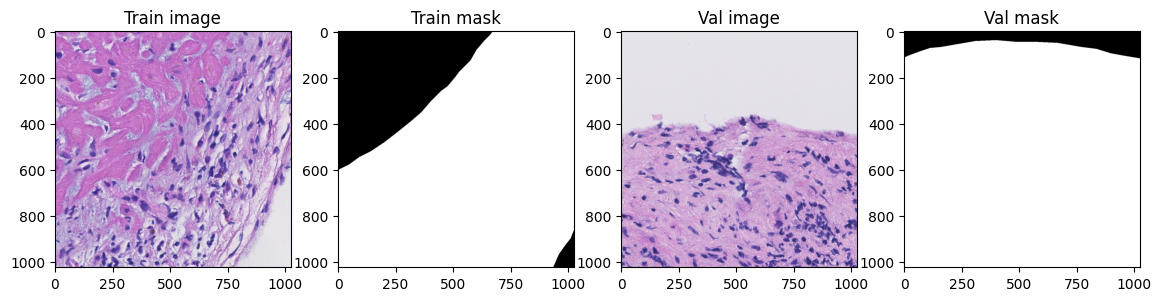

[0. 1.]
[0. 1.]


In [22]:
randTrainImgNum = random.randint(0, len(trainImgBatch_quilty)-1)
randValImgNum = random.randint(0, len(valImgBatch_quilty)-1)
print(randTrainImgNum)
print(randValImgNum)

trainImgExample = trainImgBatch_quilty[randTrainImgNum]
trainMaskExample = trainMaskBatch_quilty[randTrainImgNum]

valImgExample = valImgBatch_quilty[randValImgNum]
valMaskExample = valMaskBatch_quilty[randValImgNum]

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.title('Train image')
plt.imshow(trainImgExample.astype('uint8'))
plt.subplot(142)
plt.title('Train mask')
plt.imshow(trainMaskExample[:,:,0], cmap='gray')
plt.subplot(143)
plt.title('Val image')
plt.imshow(valImgExample.astype('uint8'))
plt.subplot(144)
plt.title('Val mask')
plt.imshow(valMaskExample[:,:,0], cmap='gray')
plt.show()
print(np.unique(trainMaskExample))
print(np.unique(valMaskExample))

### Training

In [9]:
# Unet Model
tf.compat.v1.disable_eager_execution()

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
quilty_tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(),'Tensorboard','Binary','ResNet34','Quilty'))
quilty_callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(),'Saved Models','Binary','ResNet34','Quilty_uNet_ResNet34_model.hdf5'),
                                                         monitor='val_loss', mode='min',
                                                         save_best_only=True), quilty_tensorboard]

quilty_uNetModel = sm.Unet(backbone_name = backbone, activation = 'sigmoid')
quilty_uNetModel.summary()

quilty_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

numTrainImgs = len(os.listdir(os.path.join(quilty_trainImgPath,'train')))
numValImgs = len(os.listdir(os.path.join(quilty_valImgPath,'val')))
trainStepsPerEpoch = numTrainImgs//batchSize
valStepsPerEpoch = numValImgs//batchSize

quilty_uNetModel_history = quilty_uNetModel.fit(trainDataGen_quilty,
                                  steps_per_epoch=trainStepsPerEpoch,
                                  epochs=100,
                                  callbacks=quilty_callbacks_list,
                                  validation_data=valDataGen_quilty,
                                  validation_steps=valStepsPerEpoch)


2022-09-28 09:50:40.548161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 09:50:41.830456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 09:50:42.734798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

2022-09-28 09:50:48.708148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 09:50:50.288700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 09:50:50.588493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-09-28 09:50:51.290152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 09:50:56.552383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

### Evaluating

In [48]:
quilty_uNetModel = keras.models.load_model('/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Notebook/CardiacBiopsyDL/Saved Models/Binary/ResNet34/Quilty_uNet_ResNet34_model.hdf5', compile=False)

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
quilty_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [14]:
quilty_valSteps = len(os.listdir(os.path.join(quilty_valImgPath,'val')))//batchSize
quilty_uNetModel.evaluate_generator(valDataGen_quilty, quilty_valSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_875/3580134966.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  quilty_uNetModel.evaluate_generator(valDataGen_quilty, quilty_valSteps)


Found 63 images belonging to 1 classes.
Found 63 images belonging to 1 classes.


2022-09-28 10:59:28.556948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.3656448423862457, 0.6343550682067871, 0.8417689204216003]

In [15]:
quily_testSteps = len(os.listdir(os.path.join(quilty_testImgPath,'test')))/batchSize
quilty_uNetModel.evaluate_generator(testDataGen_quilty, quily_testSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_875/3626995852.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  quilty_uNetModel.evaluate_generator(testDataGen_quilty, quily_testSteps)


Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.


[0.3866436183452606, 0.6164909601211548, 0.8271387815475464]

In [ ]:
quilty_uNetModel_epochs = range(1, len(quilty_uNetModel_history.history['loss']) + 1)
quilty_uNetModel_loss = quilty_uNetModel_history.history['loss']
quilty_uNetModel_valLoss = quilty_uNetModel_history.history['val_loss']

plt.figure()
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_loss, color='red', label='Training loss')
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_valLoss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
quilty_uNetModel_epochs = range(1, len(quilty_uNetModel_history.history['loss']) + 1)
quilty_uNetModel_IoUscore = quilty_uNetModel_history.history['iou_score']
quilty_uNetModel_valIoUscore = quilty_uNetModel_history.history['val_iou_score']

plt.figure()
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_IoUscore, color='red', label='Training IoU score')
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_valIoUscore, color='green', label='Validation IoU score')
plt.title('Training and validation IoU score')
plt.legend()

In [ ]:
quilty_uNetModel_epochs = range(1, len(quilty_uNetModel_history.history['loss']) + 1)
quilty_uNetModel_acc = quilty_uNetModel_history.history['acc']
quilty_uNetModel_valAcc = quilty_uNetModel_history.history['val_acc']

plt.figure()
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_acc, color='red', label='Training acc')
plt.plot(quilty_uNetModel_epochs, quilty_uNetModel_valAcc, color='green', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

### Testing

In [65]:
quilty_testImgBatch, quilty_testMaskBatch = testDataGen_quilty.__next__()
predictTestImg = quilty_uNetModel.predict(quilty_testImgBatch)

print('testImgs array shape: ', quilty_testImgBatch.shape)
print('testMasks array shape: ', quilty_testMaskBatch.shape)

1/1 [==============================] - 2s 2s/step
testImgs array shape:  (2, 1024, 1024, 3)
testMasks array shape:  (2, 1024, 1024, 1)


0


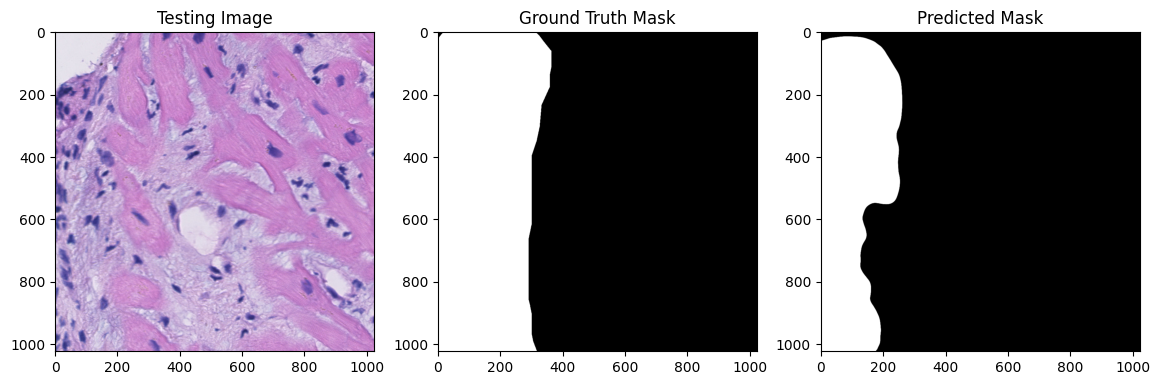

[0. 1.]
[2.0050765e-13 2.0290231e-13 2.0338250e-13 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


In [66]:
#Test some random images from
randTestImgNum = random.randint(0, len(quilty_testImgBatch)-1)
print(randTestImgNum)
testImg = quilty_testImgBatch[randTestImgNum]
groundTruthMask = quilty_testMaskBatch[randTestImgNum]
predictedMask = predictTestImg[randTestImgNum]

plt.figure(figsize=(14, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImg.astype('uint8'))
plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(groundTruthMask, cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predictedMask, cmap='gray')
plt.show()
print(np.unique(groundTruthMask))
print(np.unique(predictedMask))